In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def read_bl2(path):
    return np.core.records.fromfile(str(path),formats='i8,(2048)i2',names='index,wave')

In [3]:
def read_truth(path):
    return np.core.records.fromfile(str(path),formats='i8,i2,i2,(6)i2,i2,i2',names='index,label,numPro,naught,T0,max')

In [4]:
basepath = Path("/Users/elicarter/Local/FominResearch/RealData/Runs/pseudoData/sim100k_wfs.dat")
data = read_bl2(basepath)["wave"]
#CUT OFF AT 10K EVENTS
cutOff = 10000
trainingData = data[:cutOff] 
data = data[cutOff:]

In [5]:
truthTable = read_truth(Path("/Users/elicarter/Local/FominResearch/RealData/Runs/pseudoData/sim100k_proEventList.dat"))["label"]
trainingTruthTable = truthTable[:cutOff]
dataTruthTable = truthTable[cutOff:]

In [6]:
gc.collect()

119

# Dimensionality Reduction using principal component analysis

In [7]:
u, s, vh = np.linalg.svd(data, full_matrices=False)

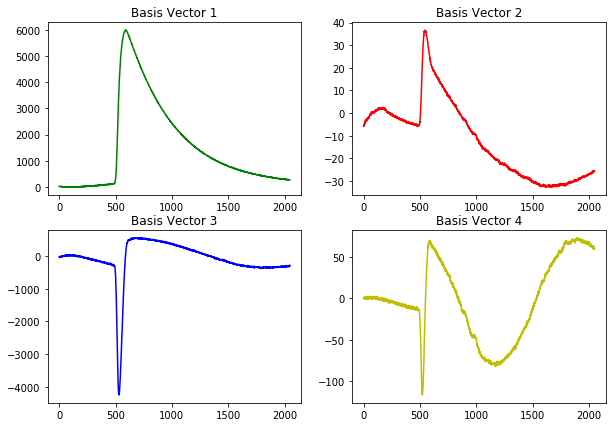

In [8]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

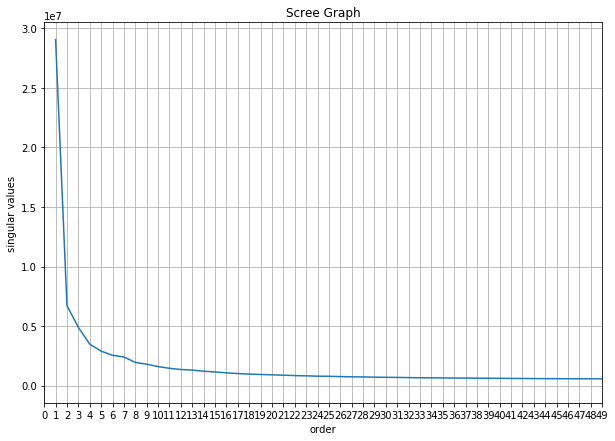

In [9]:
scree_order = np.arange(1,len(s)+1)
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,50))
plt.grid()
plt.show()

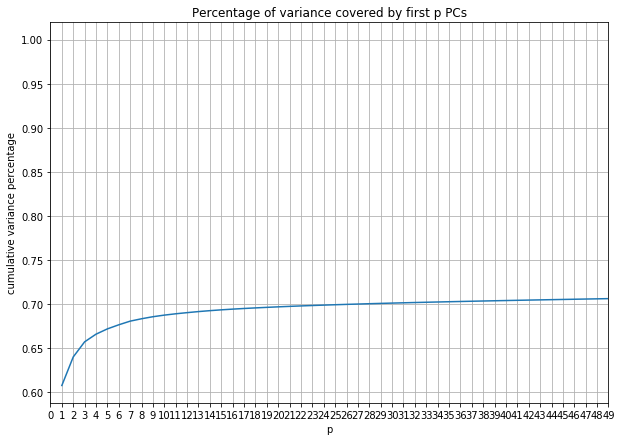

In [10]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]
    
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance
    
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,50))
plt.grid()
plt.show()

In [11]:
v = np.transpose(vh)
vD = v
trainingDataD = trainingData@vD
rDataD = data@vD

# Start SVM

In [17]:
#set up weights
weights = {0:8,1:8,2:8,3:8,4:8,5:8,6:1,7:1,8:1}

In [18]:
clf = svm.SVC(class_weight=weights)
clf.fit(trainingData, trainingTruthTable)

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 8, 1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 1, 7: 1, 8: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [19]:
print(trainingData.shape)
print(data.shape)
print(trainingTruthTable.shape)

(10000, 2048)
(90000, 2048)
(10000,)


In [20]:
labels = clf.predict(data)
print(accuracy_score(dataTruthTable, labels))

0.9939777777777777


In [21]:
df = pd.DataFrame(confusion_matrix(dataTruthTable, labels))

In [22]:
df

,0,1,2,3,4,5,6,7,8
0,1946,0,0,0,0,0,0,0,0
1,0,81060,0,0,0,0,0,0,0
2,0,3,5035,0,0,0,2,0,0
3,0,0,2,209,0,0,0,0,0
4,1,0,0,0,130,33,0,38,1
5,1,2,10,4,8,152,30,0,23
6,0,11,3,10,7,48,115,5,2
7,0,2,0,0,132,14,0,60,0
8,40,110,0,0,0,0,0,0,751
